Generating sample classification data...
Starting hyperparameter optimization for GPC with NelderMead{Optim.AffineSimplexer, Optim.AdaptiveParameters}...
Σ for i=96: 1.0
Σ for i=53: 0.9809518391971871
Σ for i=35: 0.9663825644455835
Σ for i=21: 0.9742355238404906
Σ for i=93: 0.8242451151826333
Σ for i=1: 0.7025122639630262
Σ for i=57: 0.6280728938727634
Σ for i=20: 0.5785975410013366
Σ for i=55: 0.91918851583635
Σ for i=68: 0.6318945610336104
Σ for i=37: 0.522732434242466
Σ for i=54: 0.5108760321402164
Σ for i=84: 0.5314927295670752
Σ for i=85: 0.46242554332706576
Σ for i=47: 0.46357441433206864
Σ for i=50: 0.40198232004383777
Σ for i=2: 0.5136187456968908
Σ for i=18: 0.456004201889432
Σ for i=64: 0.46443614654436066
Σ for i=62: 0.39624378909383823
Σ for i=66: 0.4962251063555555
Σ for i=99: 0.3711969983334212
Σ for i=34: 0.3334980843086023
Σ for i=48: 0.7742321606576335
Σ for i=58: 0.34688532123113847
Σ for i=91: 0.3980892627656512
Σ for i=17: 0.595905356425689
Σ for i=94: 0.31823565023

Excessive output truncated after 524297 bytes.

Σ for i=36: 0.03166677172417436
Σ for i=65: 0.03355927352407093
Σ for i=39: 0.028813869246710422
Σ for i=53: 0.033915472655614516
Σ for i=77: 0.04307946133928963
Σ for i=25: 0.03019067855426048
Σ for i=19: 0.039444408103478115
Σ for i=27: 0.04134347390552846
Σ for i=70: 0.0363691607228118
Σ for i=81: 0.033989902764097836
Σ for i=99: 0.04136793003444329
Σ for i=94: 0.04022330964351642
Σ for i=33: 0.031183348655500705
Σ for i=18: 0.03634858463280853
Σ for i=22: 0.029010091799161166
Σ for i=13: 0.033246087162996436
Σ for i=74: 0.03360298620170079
Σ for i=17: 0.04266919006512045
Σ for i=44: 0.032556531525301205
Σ for i=46: 0.03486163838808557
Σ for i=84: 0.08850379407053034
Σ for i=29: 0.03579922597870314
Σ for i=4: 0.029040547234979525
Σ for i=97: 0.03638190864431742
Σ for i=98: 0.04830862977752699
Σ for i=48: 0.08297925371576745
Σ for i=82: 0.033440358561895096
Σ for i=96: 0.04704411670435792
Σ for i=72: 0.04011183453686384
Σ for i=15: 0.0374154501145343
Σ for i=16: 0.029036519092207728


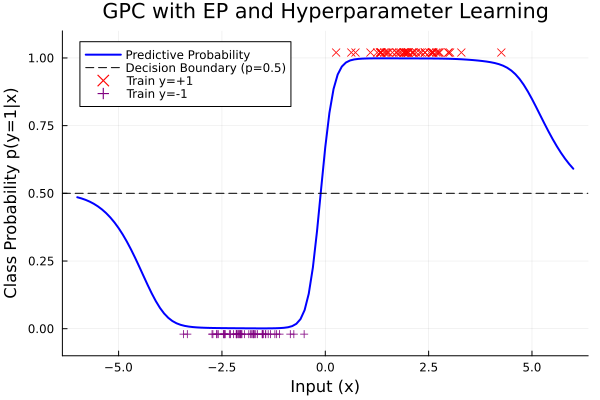

In [3]:
using LinearAlgebra
using Optim
using Zygote
using Plots
using Distributions
using Random

# ------------------------------------------------------------------
# ガウス過程分類器の構造体
# ------------------------------------------------------------------
mutable struct GPC
    X::Matrix{Float64}
    y::Vector{Float64}
    log_σf²::Float64
    log_ℓ::Vector{Float64}
    μ::Vector{Float64}
    Σ::Matrix{Float64}
    τ̃::Vector{Float64}
    ν̃::Vector{Float64}

    function GPC(X, y; σf²=1.0, ℓ=1.0)
        n, d = size(X)
        log_σf² = log(σf²)
        log_ℓ = typeof(ℓ) <: Real ? fill(log(ℓ), d) : log.(ℓ)
        new(X, y, log_σf², log_ℓ, zeros(n), zeros(n, n), zeros(n), zeros(n))
    end
end

# ------------------------------------------------------------------
# 共分散関数（カーネル）
# ------------------------------------------------------------------
function se_kernel(X₁::AbstractMatrix, X₂::AbstractMatrix, log_σf²::Float64, log_ℓ::Vector{Float64})
    σf² = exp(log_σf²)
    ℓ = exp.(log_ℓ)
    d = size(X₁, 2)
    sq_dist = sum( ((X₁[:, i] .- X₂[:, i]') ./ ℓ[i]).^2 for i in 1:d )
    return σf² .* exp.(-0.5 .* sq_dist)
end

# ------------------------------------------------------------------
# EPアルゴリズムの実行 (内部ヘルパー関数)
# ------------------------------------------------------------------
function _run_ep!(model::GPC, K::Matrix; max_iter=50, tol=1e-4, damping=0.9)
    n = size(model.X, 1)
    model.τ̃ .= 0.0
    model.ν̃ .= 0.0
    model.Σ = copy(K)
    model.μ = zeros(n)

    for iter in 1:max_iter
        prev_μ = copy(model.μ)
        for i in 1:n |> shuffle
            τᵢ = 1.0 / model.Σ[i, i]

            println("Σ for i=$i: ", model.Σ[i, i])

            νᵢ = model.μ[i] * τᵢ
            τ₋ᵢ = τᵢ - model.τ̃[i]
            if τ₋ᵢ < 1e-8; continue; end
            ν₋ᵢ = νᵢ - model.ν̃[i]
            μ₋ᵢ = ν₋ᵢ / τ₋ᵢ
            σ²₋ᵢ = 1.0 / τ₋ᵢ
            zᵢ = model.y[i] * μ₋ᵢ / sqrt(1.0 + σ²₋ᵢ)
            Φ = cdf(Normal(), zᵢ)
            if Φ < 1e-9; continue; end
            N_pdf = pdf(Normal(), zᵢ)
            μ̂ᵢ = μ₋ᵢ + model.y[i] * σ²₋ᵢ * N_pdf / (Φ * sqrt(1.0 + σ²₋ᵢ))
            σ̂²ᵢ = σ²₋ᵢ - (σ²₋ᵢ^2 * N_pdf / ((1.0 + σ²₋ᵢ) * Φ)) * (zᵢ + N_pdf / Φ)
            Δτ = 1.0/max(σ̂²ᵢ, 1e-8) - τ₋ᵢ
            Δν = μ̂ᵢ/max(σ̂²ᵢ, 1e-8) - ν₋ᵢ
            new_τ̃ᵢ = (1-damping) * model.τ̃[i] + damping * (model.τ̃[i] + Δτ)
            new_ν̃ᵢ = (1-damping) * model.ν̃[i] + damping * (model.ν̃[i] + Δν)
            Δτ_damped = new_τ̃ᵢ - model.τ̃[i]
            model.τ̃[i] = new_τ̃ᵢ
            model.ν̃[i] = new_ν̃ᵢ
            sᵢ = model.Σ[:, i]
            denom = 1.0 + Δτ_damped * model.Σ[i, i]
            if abs(denom) < 1e-8; continue; end
            model.Σ -= (sᵢ * sᵢ' * Δτ_damped) ./ denom
            model.μ = model.Σ * model.ν̃
        end

        # モニタリング
        # println("Iteration $iter: max Δμ = ", norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8))

        if norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8) < tol
            return true
        end
    end
    return false
end

# ------------------------------------------------------------------
# 近似対数周辺尤度 (目的関数)
# ------------------------------------------------------------------
function negative_log_approx_marginal_likelihood(θ::Vector, X::Matrix, y::Vector)
    log_σf² = θ[1]
    log_ℓ = θ[2:end]
    K = se_kernel(X, X, log_σf², log_ℓ)
    temp_model = GPC(X, y, σf²=exp(log_σf²), ℓ=exp.(log_ℓ))
    if !_run_ep!(temp_model, K, max_iter=20)
        return 1e10
    end
    τ̃_safe = max.(temp_model.τ̃, 1e-8)
    Σ̃ = Diagonal(1.0 ./ τ̃_safe)
    μ̃ = temp_model.ν̃ ./ τ̃_safe
    Ky = K + Σ̃
    if !isposdef(Ky); return 1e10; end
    L_Ky = cholesky(Symmetric(Ky)).L
    log_Z_EP = -0.5 * logdet(L_Ky) * 2 - 0.5 * dot(μ̃, Ky \ μ̃)
    return -log_Z_EP
end

# ------------------------------------------------------------------
# モデルの学習 (ハイパーパラメータ最適化)
# ------------------------------------------------------------------
function fit!(model::GPC; optimiser_alg = LBFGS())
    d = size(model.X, 2)
    θ₀ = [model.log_σf²; model.log_ℓ]
    loss = θ -> negative_log_approx_marginal_likelihood(θ, model.X, model.y)

    println("Starting hyperparameter optimization for GPC with $(string(typeof(optimiser_alg)))...")
    
    # 解析的勾配の実装は複雑なため、Zygoteは一旦コメントアウト
    # 勾配なしのNelderMeadを推奨
    # ∇loss! = ... 
    results = optimize(loss, θ₀, optimiser_alg, Optim.Options(iterations=100, show_trace=true))
    
    θ_opt = Optim.minimizer(results)
    println("Optimization finished.")
    
    model.log_σf² = θ_opt[1]
    model.log_ℓ = θ_opt[2:end]
    
    println("\nOptimized hyperparameters:")
    println("  - Signal variance (σf²): ", exp(model.log_σf²))
    println("  - Length scale (ℓ): ", exp.(model.log_ℓ))
    
    println("Running final EP with optimized hyperparameters...")
    K = se_kernel(model.X, model.X, model.log_σf², model.log_ℓ)
    if !_run_ep!(model, K)
        @warn "Final EP run did not converge."
    end
    
    return model
end

# ------------------------------------------------------------------
# 予測 
# ------------------------------------------------------------------
function predict(model::GPC, X★::AbstractMatrix)
    K = se_kernel(model.X, model.X, model.log_σf², model.log_ℓ)
    τ̃_safe = max.(model.τ̃, 1e-8)
    S̃_sqrt = Diagonal(sqrt.(τ̃_safe))

    B = I + S̃_sqrt * K * S̃_sqrt
    L_B = cholesky(Symmetric(B)).L

    k★ = se_kernel(model.X, X★, model.log_σf², model.log_ℓ)
    a = model.ν̃
    b = L_B' \ (L_B \ (S̃_sqrt * K * a))
    μ_f★ = k★' * (a - S̃_sqrt * b)

    v = L_B \ (S̃_sqrt * k★)
    k★★ = diag(se_kernel(X★, X★, model.log_σf², model.log_ℓ))
    var_f★ = k★★ - vec(sum(v.^2, dims=1))
    var_f★ = max.(var_f★, 1e-8)

    π★ = cdf.(Normal(), vec(μ_f★) ./ sqrt.(1.0 .+ vec(var_f★)))
    return π★
end

# ------------------------------------------------------------------
# サンプル実行 
# ------------------------------------------------------------------
println("Generating sample classification data...")
n_per_class = 50
X1 = rand(Normal(-2.0, 0.7), n_per_class, 1)
X2 = rand(Normal(2.0, 0.7), n_per_class, 1)
X_train = [X1; X2]
y_train = [fill(-1.0, n_per_class); fill(1.0, n_per_class)]

gpc = GPC(X_train, y_train, σf²=1.0, ℓ=1.0)

# 勾配なしのNelderMeadで実行
fit!(gpc, optimiser_alg = NelderMead())

xx = -6:0.1:6
X_test = reshape(xx, :, 1)
π★ = predict(gpc, X_test)

p = plot(title="GPC with EP and Hyperparameter Learning", xlabel="Input (x)", ylabel="Class Probability p(y=1|x)")
contourf!(p, xx, 0:0.1:1, (x,y) -> y, levels=π★, color=:viridis, alpha=0.5, colorbar=false)
plot!(p, xx, π★, lw=2, color=:blue, label="Predictive Probability")
hline!(p, [0.5], ls=:dash, color=:black, label="Decision Boundary (p=0.5)")
scatter!(p, X_train[y_train .== 1], fill(1.02, sum(y_train.==1)), color=:red, marker=:xcross, label="Train y=+1")
scatter!(p, X_train[y_train .== -1], fill(-0.02, sum(y_train.==-1)), color=:purple, marker=:cross, label="Train y=-1")
ylims!(-0.1, 1.1)

p

Generating sample data with outliers...
Outliers added at indices 3 and 15.
Starting MAP hyperparameter optimization for GPR with Student-t likelihood...
Σ for i=18: 1.0
Σ for i=20: 0.6866765486235535
Σ for i=14: 0.9803448254825509
Σ for i=3: 1.0
Σ for i=12: 0.6831811926314444
Σ for i=9: 0.8911508841740468
Σ for i=19: 0.12236527790924327
Σ for i=17: 0.268587867580709
Σ for i=21: 0.31062381658803845
Σ for i=2: 0.7049496592854658
Σ for i=15: 0.1893708954741851
Σ for i=1: 0.5864501943339842
Σ for i=10: 0.20177001640832087
Σ for i=16: 0.20242513732000747
Σ for i=4: 0.7018123049408181
Σ for i=13: 0.1191128430263984
Σ for i=7: 0.9970341559274485
Σ for i=22: 0.29837945299807983
Σ for i=5: 0.5290527312140753
Σ for i=11: 0.1090415508120645
Σ for i=6: 0.2596302372698053
Σ for i=8: 0.5213561055699218
Σ for i=23: 0.2962786146851132
Σ for i=19: 0.059694363050503005
Σ for i=1: 0.1338503217474572
Σ for i=3: 0.22497394137162802
Σ for i=20: 0.05233268694083709
Σ for i=21: 0.0536351476436596
Σ for i=7: 

Excessive output truncated after 524291 bytes.

Σ for i=4: -0.028653556093103633
Σ for i=14: 0.00327967153432498
Σ for i=1: 0.0006834208160193129
Σ for i=11: 0.0020977953993632005
Σ for i=10: 0.002299053931605459
Σ for i=19: 0.0020658840996831142
Σ for i=23: 0.0022876120120881214
Σ for i=15: -0.007707181652472517
Σ for i=2: -0.08144662220859508
Σ for i=22: 0.0016832020519571065
Σ for i=14: 0.0032511928435872708
Σ for i=9: 0.004806375616380103
Σ for i=5: 0.0049175280926911195
Σ for i=7: 0.04767868914104611
Σ for i=21: 0.0014576292385199256
Σ for i=8: 0.037177638871065975
Σ for i=16: -0.0014656451480043317
Σ for i=20: 0.0012618622271437744
Σ for i=3: -0.11444881371589836
Σ for i=13: 0.0049803642299501355
Σ for i=4: -0.028445503310500254
Σ for i=18: 0.0022726769253482966
Σ for i=12: 0.004097009557365169
Σ for i=6: 0.05992998534981069
Σ for i=17: 0.006394349287649485
Σ for i=21: 0.0014579354742711823
Σ for i=4: -0.028445503298270447
Σ for i=8: 0.03717764859759828
Σ for i=6: 0.05992998538345906
Σ for i=20: 0.0012619953492206191
Σ for i=1

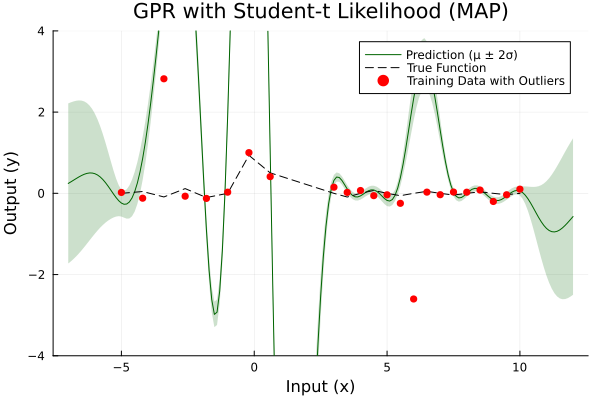

In [1]:
using LinearAlgebra
using Optim
using Plots
using Distributions
using Random
using QuadGK

# ------------------------------------------------------------------
# Student-t GPR の構造体 (変更なし)
# ------------------------------------------------------------------
mutable struct GPRT_EP
    X::Matrix{Float64}
    y::Vector{Float64}
    log_σf²::Float64
    log_ℓ::Vector{Float64}
    log_ν::Float64
    log_σ::Float64
    μ::Vector{Float64}
    Σ::Matrix{Float64}
    τ̃::Vector{Float64}
    ν̃::Vector{Float64}

    function GPRT_EP(X, y; σf²=1.0, ℓ=1.0, ν=4.0, σ=0.1)
        n, d = size(X)
        log_σf² = log(σf²)
        log_ℓ = typeof(ℓ) <: Real ? fill(log(ℓ), d) : log.(ℓ)
        log_ν = log(ν)
        log_σ = log(σ)
        new(X, y, log_σf², log_ℓ, log_ν, log_σ, zeros(n), zeros(n, n), zeros(n), zeros(n))
    end
end

# ------------------------------------------------------------------
# 共分散関数（変更なし）
# ------------------------------------------------------------------
function se_kernel(X₁::AbstractMatrix, X₂::AbstractMatrix, log_σf²::Float64, log_ℓ::Vector{Float64})
    σf² = exp(log_σf²)
    ℓ = exp.(log_ℓ)
    d = size(X₁, 2)
    sq_dist = sum( ((X₁[:, i] .- X₂[:, i]') ./ ℓ[i]).^2 for i in 1:d )
    return σf² .* exp.(-0.5 .* sq_dist)
end

# ------------------------------------------------------------------
# モーメント計算 (変更なし)
# ------------------------------------------------------------------
function calculate_moments_student_t(μ₋ᵢ, σ²₋ᵢ, yᵢ, ν, σ)
    integrand(f) = pdf(Normal(μ₋ᵢ, sqrt(σ²₋ᵢ)), f) * pdf(LocationScale(f, σ, TDist(ν)), yᵢ)
    Ẑᵢ, _ = quadgk(integrand, -Inf, Inf, rtol=1e-5)
    if Ẑᵢ < 1e-10; return (Inf, Inf, Inf); end
    integral_μ, _ = quadgk(f -> f * integrand(f), -Inf, Inf, rtol=1e-5)
    μ̂ᵢ = integral_μ / Ẑᵢ
    integral_var, _ = quadgk(f -> (f - μ̂ᵢ)^2 * integrand(f), -Inf, Inf, rtol=1e-5)
    σ̂²ᵢ = integral_var / Ẑᵢ
    return Ẑᵢ, μ̂ᵢ, σ̂²ᵢ
end

# ------------------------------------------------------------------
# EPアルゴリズムの実行 (変更なし)
# ------------------------------------------------------------------
function _run_ep!(model::GPRT_EP, K::Matrix; max_iter=50, tol=1e-5, damping=0.8)
    n = size(model.X, 1)
    ν = exp(model.log_ν)
    σ = exp(model.log_σ)
    model.τ̃ .= 0.0
    model.ν̃ .= 0.0
    model.Σ = copy(K)
    model.μ = zeros(n)
    for iter in 1:max_iter
        prev_μ = copy(model.μ)
        for i in 1:n |> shuffle
            τᵢ = 1.0 / model.Σ[i, i]

            println("Σ for i=$i: ", model.Σ[i, i])

            νᵢ = model.μ[i] * τᵢ
            τ₋ᵢ = τᵢ - model.τ̃[i]
            if τ₋ᵢ < 1e-8; continue; end
            ν₋ᵢ = νᵢ - model.ν̃[i]
            μ₋ᵢ = ν₋ᵢ / τ₋ᵢ
            σ²₋ᵢ = 1.0 / τ₋ᵢ
            _, μ̂ᵢ, σ̂²ᵢ = calculate_moments_student_t(μ₋ᵢ, σ²₋ᵢ, model.y[i], ν, σ)
            if isinf(μ̂ᵢ) || σ̂²ᵢ <= 0; continue; end
            Δτ = 1.0/σ̂²ᵢ - τ₋ᵢ
            Δν = μ̂ᵢ/σ̂²ᵢ - ν₋ᵢ
            new_τ̃ᵢ = (1-damping) * model.τ̃[i] + damping * (model.τ̃[i] + Δτ)
            new_ν̃ᵢ = (1-damping) * model.ν̃[i] + damping * (model.ν̃[i] + Δν)
            Δτ_damped = new_τ̃ᵢ - model.τ̃[i]
            model.τ̃[i] = new_τ̃ᵢ
            model.ν̃[i] = new_ν̃ᵢ
            sᵢ = model.Σ[:, i]
            denom = 1.0 + Δτ_damped * model.Σ[i, i]
            if abs(denom) < 1e-8; continue; end
            model.Σ -= (sᵢ * sᵢ' * Δτ_damped) ./ denom
            model.μ = model.Σ * model.ν̃
        end

        # # モニタリング
        # println("Iteration $iter: max Δμ = ", norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8))

        if norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8) < tol
            return true
        end
    end
    @warn "EP did not converge in $max_iter iterations."
    return false
end

# ------------------------------------------------------------------
# 対数事前分布 log p(θ) - ★★★ 新規追加 ★★★
# ------------------------------------------------------------------
function log_prior(θ::Vector)
    d = length(θ) - 3
    log_σf², log_ℓ, log_ν, log_σ = θ[1], θ[2:d+1], θ[d+2], θ[d+3]

    # 各ハイパーパラメータの対数値に対する事前分布
    prior_σf² = Normal(0.0, 1.0)
    prior_ℓ   = Normal(log(1.0), 1.0) # 長さスケールの事前知識に応じて調整
    prior_ν   = Normal(log(4.0), 1.0) # 自由度νが4あたりになるように
    prior_σ   = Normal(log(0.1), 1.0) # ノイズスケールσが0.1あたりになるように

    lp = logpdf(prior_σf², log_σf²)
    lp += sum(logpdf.(prior_ℓ, log_ℓ))
    lp += logpdf(prior_ν, log_ν)
    lp += logpdf(prior_σ, log_σ)
    
    return lp
end

# ------------------------------------------------------------------
# 近似対数周辺尤度 (内部ヘルパー関数)
# ------------------------------------------------------------------
function _negative_log_approx_marginal_likelihood(θ::Vector, X::Matrix, y::Vector)
    d = size(X, 2)
    log_σf², log_ℓ, log_ν, log_σ = θ[1], θ[2:d+1], θ[d+2], θ[d+3]

    K = se_kernel(X, X, log_σf², log_ℓ)
    temp_model = GPRT_EP(X, y, σf²=exp(log_σf²), ℓ=exp.(log_ℓ), ν=exp(log_ν), σ=exp(log_σ))
    
    if !_run_ep!(temp_model, K, max_iter=10000)
        return 1e10
    end
    
    τ̃_safe = max.(temp_model.τ̃, 1e-8)
    Σ̃ = Diagonal(1.0 ./ τ̃_safe)
    μ̃ = temp_model.ν̃ ./ τ̃_safe
    Ky = K + Σ̃
    if !isposdef(Ky); return 1e10; end
    L_Ky = cholesky(Symmetric(Ky)).L
    
    log_Z_EP = -0.5 * logdet(L_Ky) * 2 - 0.5 * dot(μ̃, Ky \ μ̃)
    
    return -log_Z_EP
end

# ------------------------------------------------------------------
# 負の対数事後確率 (新しい目的関数) - ★★★ 新規追加 ★★★
# ------------------------------------------------------------------
function negative_log_posterior(θ::Vector, X::Matrix, y::Vector)
    # -log p(D|θ)
    nll = _negative_log_approx_marginal_likelihood(θ, X, y)
    if isinf(nll) || nll > 1e9
        return nll
    end
    
    # log p(θ)
    lp = log_prior(θ)
    
    # 最小化対象: -log p(D|θ) - log p(θ)
    return nll - lp
end


# ------------------------------------------------------------------
# モデルの学習 (MAP推定) - ★★★ 修正箇所 ★★★
# ------------------------------------------------------------------
function fit!(model::GPRT_EP; optimiser_alg = NelderMead(), options=Optim.Options(iterations=50))
    d = size(model.X, 2)
    θ₀ = [model.log_σf², model.log_ℓ..., model.log_ν, model.log_σ]
    
    # 目的関数を対数事後確率に変更
    loss(θ) = negative_log_posterior(θ, model.X, model.y)

    println("Starting MAP hyperparameter optimization for GPR with Student-t likelihood...")
    results = optimize(loss, θ₀, optimiser_alg, options)
    
    θ_opt = Optim.minimizer(results)
    println("Optimization finished.")
    
    model.log_σf² = θ_opt[1]
    model.log_ℓ = θ_opt[2:d+1]
    model.log_ν = θ_opt[d+2]
    model.log_σ = θ_opt[d+3]
    
    println("\nOptimized hyperparameters (MAP):")
    println("  - Signal variance (σf²): ", exp(model.log_σf²))
    println("  - Length scale (ℓ): ", exp.(model.log_ℓ))
    println("  - Degrees of Freedom (ν): ", exp(model.log_ν))
    println("  - Noise scale (σ): ", exp(model.log_σ))
    
    println("Running final EP with optimized hyperparameters...")
    K = se_kernel(model.X, model.X, model.log_σf², model.log_ℓ)
    if !_run_ep!(model, K)
        @warn "Final EP run did not converge."
    end
    
    return model
end

# ------------------------------------------------------------------
# 予測 (変更なし)
# ------------------------------------------------------------------
function predict(model::GPRT_EP, X★::AbstractMatrix)
    K = se_kernel(model.X, model.X, model.log_σf², model.log_ℓ)
    k★ = se_kernel(model.X, X★, model.log_σf², model.log_ℓ)
    k★★ = diag(se_kernel(X★, X★, model.log_σf², model.log_ℓ))
    K_inv = inv(Symmetric(K))
    μ★ = k★' * K_inv * model.μ
    var★ = k★★ - diag(k★' * (K_inv - K_inv * model.Σ * K_inv) * k★)
    var★ = max.(var★, 1e-8)
    return vec(μ★), sqrt.(var★)
end

# ------------------------------------------------------------------
# サンプル実行
# ------------------------------------------------------------------
println("Generating sample data with outliers...")
X_train_vec = sort(vcat(-5:0.8:1, 3:0.5:10))
X_train = reshape(X_train_vec, :, 1)
y_true = vec(sinc.(X_train))
y_train = y_true .+ 0.1 .* randn(length(y_true))
y_train[3] += 3.0
y_train[15] -= 2.5
println("Outliers added at indices 3 and 15.")

gprt = GPRT_EP(X_train, y_train, σf²=1.0, ℓ=1.0, ν=4.0, σ=0.3)
fit!(gprt, options=Optim.Options(iterations=1000, show_trace=true))

X_test = reshape(-7:0.1:12, :, 1)
μ, σ = predict(gprt, X_test)

p = plot(vec(X_test), μ, ribbon=2*σ, fillalpha=0.2, label="Prediction (μ ± 2σ)", color=:darkgreen)
plot!(p, vec(X_train), y_true, ls=:dash, color=:black, label="True Function")
scatter!(p, vec(X_train), y_train, label="Training Data with Outliers", color=:red, markerstrokewidth=0)
plot!(p, title="GPR with Student-t Likelihood (MAP)", xlabel="Input (x)", ylabel="Output (y)")
ylims!(-4, 4)

p

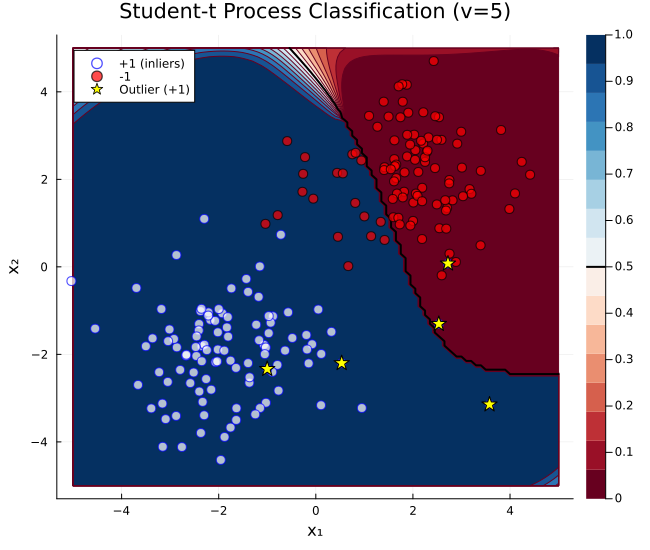

In [5]:
using LinearAlgebra
using Optim
using Plots
using Distributions
using Random

# ------------------------------------------------------------------
# t過程分類器の構造体
# ------------------------------------------------------------------
mutable struct TPC # t-Process Classifier
    X::Matrix{Float64}
    y::Vector{Float64}
    v::Float64          # ★ t分布の自由度
    log_σf²::Float64
    log_ℓ::Vector{Float64}

    # EP法で使われるパラメータ
    μ::Vector{Float64}
    Σ::Matrix{Float64}
    τ̃::Vector{Float64}
    ν̃::Vector{Float64}

    function TPC(X, y; v=10.0, σf²=1.0, ℓ=1.0)
        n, d = size(X)
        log_σf² = log(σf²)
        log_ℓ = typeof(ℓ) <: Real ? fill(log(ℓ), d) : log.(ℓ)
        new(X, y, v, log_σf², log_ℓ, zeros(n), zeros(n, n), zeros(n), zeros(n))
    end
end

# ------------------------------------------------------------------
# 共分散関数（カーネル）
# ------------------------------------------------------------------
function se_kernel(X₁::AbstractMatrix, X₂::AbstractMatrix, log_σf²::Float64, log_ℓ::Vector{Float64})
    σf² = exp(log_σf²)
    ℓ = exp.(log_ℓ)
    d = size(X₁, 2)
    sq_dist = sum( ((X₁[:, i] .- X₂[:, i]') ./ ℓ[i]).^2 for i in 1:d )
    return σf² .* exp.(-0.5 .* sq_dist)
end

# ------------------------------------------------------------------
# EPアルゴリズムの実行 (t過程版)
# ------------------------------------------------------------------
function _run_ep!(model::TPC, K::Matrix; max_iter=50, tol=1e-4, damping=0.9, ε=1e-3)
    n = size(model.X, 1)
    # EPパラメータの初期化
    model.τ̃ .= 0.0
    model.ν̃ .= 0.0
    model.Σ = copy(K) # 事前分布は St(0, K, v) だが、共分散行列は同じK
    model.μ = zeros(n)

    # 自由度の関係式 (論文 eq. (48) 参照)
    # サイト近似は1次元なので k=1
    ṽ = model.v + n - 1

    for iter in 1:max_iter
        prev_μ = copy(model.μ)
        for i in 1:n |> shuffle
            # キャビティ分布の計算 (論文 eq. (72, 73) に基づく)
            μᵢ = model.μ[i]
            σ²ᵢ = model.Σ[i, i]

            println("Σ for i=$i: ", model.Σ[i, i])            

            # 自由度を v から ṽ に補正 (論文 Appendix E.1)
            σ_prime_sq_i = σ²ᵢ * model.v / ṽ

            τᵢ = 1.0 / σ_prime_sq_i
            νᵢ = μᵢ / σ_prime_sq_i

            τ₋ᵢ = τᵢ - model.τ̃[i]
            if τ₋ᵢ < 1e-8; continue; end
            ν₋ᵢ = νᵢ - model.ν̃[i]

            μ₋ᵢ = ν₋ᵢ / τ₋ᵢ
            σ²₋ᵢ = 1.0 / τ₋ᵢ

            # モーメントマッチング (論文 eq. (74-76) に基づく)
            # 尤度はステップ関数 p(yᵢ|fᵢ) = ε + (1-2ε)Θ(yᵢfᵢ) (論文 eq. (55))
            z = model.y[i] * μ₋ᵢ / sqrt(σ²₋ᵢ)

            dist_t_cavity = TDist(ṽ)
            cdf_t = cdf(dist_t_cavity, z)
            pdf_t = pdf(dist_t_cavity, z)

            Z₂ = ε + (1-2ε) * cdf_t
            if Z₂ < 1e-9; continue; end

            α = (1-2ε) * pdf_t / (Z₂ * sqrt(σ²₋ᵢ))

            μ̂ᵢ = μ₋ᵢ + σ²₋ᵢ * α * model.y[i]
            σ̂²ᵢ = σ²₋ᵢ * (1.0 - σ²₋ᵢ * α * (model.y[i]*z + α*σ²₋ᵢ) )

            # サイトパラメータと事後分布の更新
            σ̂²ᵢ = max(σ̂²ᵢ, 1e-8)
            Δτ = 1.0/σ̂²ᵢ - τ₋ᵢ
            Δν = μ̂ᵢ/σ̂²ᵢ - ν₋ᵢ

            new_τ̃ᵢ = (1-damping) * model.τ̃[i] + damping * (model.τ̃[i] + Δτ)
            new_ν̃ᵢ = (1-damping) * model.ν̃[i] + damping * (model.ν̃[i] + Δν)
            Δτ_damped = new_τ̃ᵢ - model.τ̃[i]

            model.τ̃[i] = new_τ̃ᵢ
            model.ν̃[i] = new_ν̃ᵢ

            # 事後分布の更新 (GPCと同様のランク1更新で近似)
            sᵢ = model.Σ[:, i]
            denom = 1.0 + Δτ_damped * σ²ᵢ
            if abs(denom) < 1e-8; continue; end
            model.Σ -= (sᵢ * sᵢ' * Δτ_damped) ./ denom
            model.μ = model.Σ * model.ν̃
        end

        # モニタリング
        println("Iteration $iter: max Δμ = ", norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8))

        if norm(model.μ - prev_μ) / max(norm(prev_μ), 1e-8) < tol
            return true
        end
    end
    return false
end


# ------------------------------------------------------------------
# モデルの学習（ハイパーパラメータは固定）
# ------------------------------------------------------------------
function fit!(model::TPC)
    println("Running EP for t-Process Classifier...")
    K = se_kernel(model.X, model.X, model.log_σf², model.log_ℓ)
    if !_run_ep!(model, K, max_iter=20)
        @warn "EP run did not converge."
    end
    return model
end

# ------------------------------------------------------------------
# 予測
# ------------------------------------------------------------------
function predict(model::TPC, X★::AbstractMatrix)
    # 潜在変数 f* の予測分布を計算 (論文 Appendix E.3)
    k★ = se_kernel(model.X, X★, model.log_σf², model.log_ℓ)
    μ_f★ = k★' * (model.Σ \ model.μ)
    v_f★ = diag(se_kernel(X★, X★, model.log_σf², model.log_ℓ)) .- vec(sum((model.Σ \ k★) .* k★, dims=1))
    v_f★ = max.(v_f★, 1e-8)

    # 予測分布は St(μ_f★, ..., v+n) (論文 eq. (83))
    v_pred = model.v + size(model.X, 1)

    # 最終的な予測確率を計算
    dist_t_pred = TDist(v_pred)
    π★ = cdf.(dist_t_pred, vec(μ_f★) ./ sqrt.(v_f★))

    return π★
end

# ------------------------------------------------------------------
# --- Sample Execution (外れ値ありのデータセット) ---
# ------------------------------------------------------------------

# 外れ値ありの2次元データを生成するヘルパー関数
function generate_outlier_data(n_per_class::Int, noise::Float64, n_outliers::Int)
    X1 = randn(n_per_class, 2) .+ [-2.0, -2.0]'
    y1 = fill(1.0, n_per_class)
    X2 = randn(n_per_class, 2) .+ [2.0, 2.0]'
    y2 = fill(-1.0, n_per_class)
    X_out = randn(n_outliers, 2) .+ [2.0, -2.0]'
    y_out = fill(1.0, n_outliers)
    X = [X1; X2; X_out]
    y = [y1; y2; y_out]
    return X, y, X_out
end

println("Generating 2D sample data with outliers...")
X_train, y_train, X_outliers = generate_outlier_data(100, 0.5, 5)

# --- t過程分類器の実行 ---
println("\n--- Training t-Process Classifier (v=5) ---")
# ハイパーパラメータは固定値を使用
tpc = TPC(X_train, y_train, v=5.0, σf²=1.0, ℓ=[1.5, 1.5])
fit!(tpc)

# ---- 結果の可視化 ----
println("\nPlotting results...")

# 予測用のグリッドを作成
x_range = -5:0.1:5
y_range = -5:0.1:5
grid_x = [x for x in x_range for y in y_range]
grid_y = [y for x in x_range for y in y_range]
X_test = hcat(grid_x, grid_y)

# 予測確率を計算
π_tpc = predict(tpc, X_test)
Z_tpc = reshape(π_tpc, length(y_range), length(x_range))

# 予測確率の等高線塗りつぶし
p = contourf(
    x_range, y_range, Z_tpc,
    c=:RdBu, clims=(0, 1),
    xlabel="x₁", ylabel="x₂",
    title="Student-t Process Classification (v=5)",
    legend=true,
    size=(650, 550)
)

# 決定境界 (π = 0.5) を太線で重ねる
contour!(p, x_range, y_range, Z_tpc, levels=[0.5], linewidth=2, color=:black, label="")

# 学習データをプロット
idx_pos = findall(y_train .== 1.0)
idx_neg = findall(y_train .== -1.0)
scatter!(p, X_train[idx_pos, 1], X_train[idx_pos, 2], marker=(:circle, 5, 0.7, :white, stroke(1, :blue)), label="+1 (inliers)")
scatter!(p, X_train[idx_neg, 1], X_train[idx_neg, 2], marker=(:circle, 5, 0.7, :red), label="-1")
scatter!(p, X_outliers[:, 1], X_outliers[:, 2], marker=(:star5, 8, :yellow, stroke(1, :black)), label="Outlier (+1)")

# プロットを表示
p